# Building a Llama 3 chatbot with Retrieval Augmented Generation (RAG)

This notebook shows a complete example of how to build a Llama 3 chatbot hosted on your browser that can answer questions based on your own data. We'll cover:
* How to use Llama 3 with Amazon Bedrock
* A chatbot example built with [Gradio](https://github.com/gradio-app/gradio)
* Adding RAG capability with Llama specific knowledge based on our Getting Started [guide](https://ai.meta.com/llama/get-started/)

## RAG Architecture

LLMs have unprecedented capabilities in NLU (Natural Language Understanding) & NLG (Natural Language Generation), but they have a knowledge cutoff date, and are only trained on publicly available data before that date. (March 2023 for Llama 3 8B, and December 2023 for Llama 3 70B).

RAG, invented by [Meta](https://ai.meta.com/blog/retrieval-augmented-generation-streamlining-the-creation-of-intelligent-natural-language-processing-models/) in 2020, is one of the most popular methods to augment LLMs. RAG allows enterprises to keep sensitive data on-prem and get more relevant answers from generic models without fine-tuning models for specific roles. So, enterprises with lots of data may utilize that data via RAG rather than having to invest in fine-tuning.

RAG is a method that:
* Retrieves data from outside a foundation model
* Augments your questions or prompts to LLMs by adding the retrieved relevant data as context
* Allows LLMs to answer questions about your own data, or data not publicly available when LLMs were trained
* Greatly reduces the hallucination in  model's response generation

The following diagram shows the general RAG components and process:

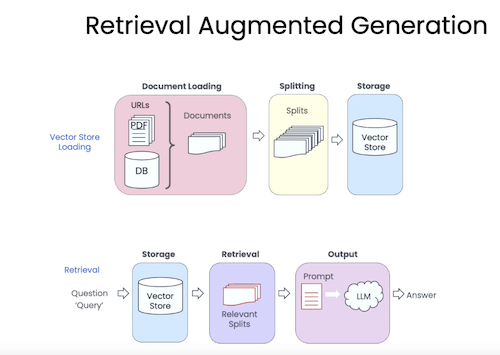

## How to Develop a RAG Powered Meta Llama 3 Chatbot

The easiest way to develop RAG-powered Meta Llama 3 chatbots is to use frameworks such as [**LangChain**](https://www.langchain.com/) and [**LlamaIndex**](https://www.llamaindex.ai/), two leading open-source frameworks for building LLM apps. Both offer convenient APIs for implementing RAG with Meta Llama 3 including:

* Load and split documents
* Embed and store document splits
* Retrieve the relevant context based on the user query
* Call Meta Llama 3 with query and context to generate the answer

LangChain is a more general purpose and flexible framework for developing LLM apps with RAG capabilities, while LlamaIndex as a data framework focuses on connecting custom data sources to LLMs. The integration of the two may provide the best performant and effective solution to building real world RAG apps.  
In our example, for simplicifty, we will use LangChain alone with locally stored PDF data.

### Install Dependencies

For this demo, we will be using the Gradio for chatbot UI, Text-generation-inference framework for model serving.  
For vector storage and similarity search, we will be using [FAISS](https://github.com/facebookresearch/faiss).  
In this example, we will be running everything in a AWS EC2 instance (i.e. [g5.2xlarge]( https://aws.amazon.com/ec2/instance-types/g5/)). g5.2xlarge features one A10G GPU. We recommend running this notebook with at least one GPU equivalent to A10G with at least 16GB video memory.  
There are certain techniques to downsize the Meta Llama 3 8B model, so it can fit into smaller GPUs. But it is out of scope here.

First, let's install all dependencies with PIP. We also recommend you start a dedicated Conda environment for better package management

In [ ]:
!pip install -r requirements.txt

### Data Processing

First run all the imports and define the path of the data and vector storage after processing.  
For the data, we will be using a raw pdf crawled from Meta Llama 3 Getting Started guide on [Meta AI website](https://ai.meta.com/llama/).

In [2]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter 

DATA_PATH = 'data' #Your root data folder path
DB_FAISS_PATH = 'vectorstore/db_faiss'

Then we use the `PyPDFDirectoryLoader` to load the entire directory. You can also use `PyPDFLoader` for loading one single file.

In [3]:
loader = PyPDFDirectoryLoader(DATA_PATH)
documents = loader.load()

Check the length and content of the doc to ensure we have loaded the right document with number of pages as 37.

In [4]:
print(len(documents), documents[0].page_content[0:100])

37 11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta
https://ai.meta.com/llama/get-started/ 1/


Split the loaded documents into smaller chunks.  
[`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.html) is one common splitter that splits long pieces of text into smaller, semantically meaningful chunks.  
Other splitters include:
* SpacyTextSplitter
* NLTKTextSplitter
* SentenceTransformersTokenTextSplitter
* CharacterTextSplitter


In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=10)
splits = text_splitter.split_documents(documents)
print(len(splits), splits[0])

103 page_content='11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 1/37\nLlama 2 Get Started FAQ Download the Model\nQuick setup and how-to guide\nGetting started\nwith Llama\nWelcome to the getting started guide for Llama.\nThis guide provides information and resources to help you set up Llama including how to access the model,\nhosting, how-to and integration guides. Additionally , you will ﬁnd supplemental materials to further assist you while\nbuilding with Llama.' metadata={'source': 'data/Llama Getting Started Guide.pdf', 'page': 0}


Note that we have set `chunk_size` to 500 and `chunk_overlap` to 10. In the spliting, these two parameters can directly affects the quality of the LLM's answers.  

Here is a good [guide](https://dev.to/peterabel/what-chunk-size-and-chunk-overlap-should-you-use-4338) on how you should carefully set these two parameters.

Next we will need to choose an embedding model for our splited documents.  

**Embeddings are numerical representations of text**. The default embedding model in HuggingFace Embeddings is `sentence-transformers/all-mpnet-base-v2` with 768 dimension. Below we use a smaller model `all-MiniLM-L6-v2` with dimension 384 so indexing runs faster.

In [8]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

Lastly, with splits and choice of the embedding model ready, we want to index them and store all the split chunks as embeddings into the vector storage.  

Vector stores are databases storing embeddings. There're at least 60 [vector stores](https://python.langchain.com/docs/integrations/vectorstores) supported by LangChain, and two of the most popular open source ones are:
* [Chroma](https://www.trychroma.com/): a light-weight and in memory so it's easy to get started with and use for **local development**.
* [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss) (Facebook AI Similarity Search): a vector store that supports search in vectors that may not fit in RAM and is appropriate for **production use**.  

Since we are running on a EC2 instance with abundant CPU resources and RAM, we will use FAISS in this example. Note that FAISS can also run on GPUs, where some of the most useful algorithms are implemented there. In that case, install `faiss-gpu` package with PIP instead.

In [9]:
db = FAISS.from_documents(splits, embeddings)
db.save_local(DB_FAISS_PATH)

Once you saved database into local path. You can find them as `index.faiss` and `index.pkl`. In the chatbot example, you can then load this database from local and plug it into our retrival process.

### Building the Chatbot UI

Now we are ready to build the chatbot UI to wire up RAG data and API server. In our example we will be using Gradio to build the Chatbot UI.  
Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications. It had been widely used by the community and HuggingFace also used Gradio to build their Chatbots. Other alternatives are: 
* [Streamlit](https://streamlit.io/)
* [Dash](https://plotly.com/dash/)
* [Flask](https://flask.palletsprojects.com/en/3.0.x/)

Again, we start by adding all the imports, paths, constants and set LangChain in debug mode, so it shows clear actions within the chain process.

In [10]:
import langchain
from queue import Queue
from typing import Any
from langchain.llms.huggingface_text_gen_inference import HuggingFaceTextGenInference
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.schema import LLMResult
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts.prompt import PromptTemplate
from anyio.from_thread import start_blocking_portal #For model callback streaming

langchain.debug=True 

#vector db path
DB_FAISS_PATH = 'vectorstore/db_faiss'

#Llama2 TGI models host port
LLAMA3_8B_HOSTPORT = "http://localhost:8080/" #Replace the locahost with the IP visible to the machine running the notebook
LLAMA3_70B_HOSTPORT = "http://localhost:8081/" # You can host multiple models if your infrastructure has capacity


model_dict = {
    "8b-instruct" : LLAMA3_8B_HOSTPORT,
    "70b-instruct" : LLAMA3_70B_HOSTPORT,
}

system_message = {"role": "system", "content": "You are a helpful assistant."}

Then we load the FAISS vector store

In [23]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.load_local(DB_FAISS_PATH, embeddings)

Next we call the Llama 3 model from Amazon Bedrock. In this example we will use the Llama 3 8b instruct model. You can find more on Llama models on the [Meta Llama in Amazon Bedrock](https://aws.amazon.com/bedrock/llama/).

At the time of writing this notebook the following Llama models are available on Bedrock:
* meta-llama-3-8b-instruct
* meta-llama-3-70b-instruct

In [24]:
# from langchain_community.llms import Bedrock
from langchain_community.llms import Bedrock

LLAMA3_70B_INSTRUCT = "meta.llama3-70b-instruct-v1:0"
LLAMA3_8B_INSTRUCT = "meta.llama3-8b-instruct-v1:0"
# We'll default to the smaller 8B model for speed; change to LLAMA3_70B_CHAT for more advanced (but slower) generations
DEFAULT_MODEL = LLAMA3_8B_INSTRUCT


llm = Bedrock(
    model_id=DEFAULT_MODEL,
    model_kwargs={"temperature": 0.0, "top_p": 1}
)

Next, we define the retriever and template for our RetrievalQA chain. For each call of the RetrievalQA, LangChain performs a semantic similarity search of the query in the vector database, then passes the search results as the context to Llama to answer the query about the data stored in the verctor database.  

Whereas for the template, this defines the format of the question along with context that we will be sent into Llama for generation. In general, Meta Llama 3 has special prompt format to handle special tokens. In some cases, the serving framework might already have taken care of it. Otherwise, you will need to write customized template to properly handle that.


In [25]:
template = """
[INST]Use the following pieces of context to answer the question. If no context provided, answer like a AI assistant.
{context}
Question: {question} [/INST]
"""

retriever = db.as_retriever(
        search_kwargs={"k": 6}
    )

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "1+1=?"
}
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "question": "1+1=?",
  "context": "numerical meaning representations, in the vector form, of the documents, to a vector store. Later when a user enters a\nquestion about the documents, the relevant data stored in the documents' vector store will be retrieved and sent, along\nwith the query , to LLM to generate an answer related to the documents. The following ﬂow shows the process:\n\nkind of output is expected. For example, if you want the model to generate a story about a particular topic, include a\n\n11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 14/37Quantization is a technique to represent the model weights which are u

Lastly, we can define the retrieval chain for QA

In [19]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, 
    retriever=retriever,     
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    }
)

Now we should have a working chain for QA. Let's test it out before wire it up with UI blocks.

In [20]:
result = qa_chain({"query": "Why choose Llama?"})
print(result)

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Why choose Llama?"
}
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "question": "Why choose Llama?",
  "context": "11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 35/37Performance & Latency\nFine Tuning\nCode LlamaLlama 2 Repository  : Main Llama 2 repository\nLlama 2 Recipes  : Examples and ﬁne tuning\nCode Llama Repository  : Main Code Llama repository\nGetting to know Llama 2  - Jupyter Notebook\nCode Llama Recipes  : Examples\nHamel’ s Blog - Optimizing and testing latency for LLMs\n\n11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 26/37INTEGRATION GUIDES\nCode Llama  is an open-source family of LLMs based on Llama 2 providing

After confirming the validity, we can start building the UI. We'll use a simple interface built out of Gradio's ChatInterface.

In [22]:
import gradio as gr

def predict(message, history):
    llm_response = qa_chain.invoke(message)["result"]
    return llm_response

gr.ChatInterface(predict).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Tell me about Llama"
}
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "question": "Tell me about Llama",
  "context": "11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 1/37\nLlama 2 Get Started FAQ Download the Model\nQuick setup and how-to guide\nGetting started\nwith Llama\nWelcome to the getting started guide for Llama.\nThis guide provides information and resources to help you set up Llama including how to access the model,\nhosting, how-to and integration guides. Additionally , you will ﬁnd supplemental materials to further assist you while\nbuilding with Llama.\n\n11/8/23, 2:00 PM Getting started with Llama 2 - AI at Meta\nhttps://ai.meta.com/llama/get-started/ 26/37INTEGRATI